# Imports

In [ ]:
!pip install --upgrade cvxpy
!pip install mosek
!pip install jaxopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn import linear_model
from scipy.optimize import curve_fit
from scipy.optimize import nnls
import cvxpy as cp
import numpy as np
import scipy as sp
# import dykstra 
import matplotlib.pyplot as plt
# import pwlf
import matplotlib.animation as animation
from matplotlib import rc

rc('animation', html='jshtml')

In [ ]:
import jax.numpy as jnp
from jax import grad, jit, vmap, nn
from jax import random

# Dynamic Fisher Market w/ linear Fitted Value Iteration

## Library

#### Utilities

In [ ]:
################### Utility Functions ##########################

def get_linear_util(demands, valuations):
    util = np.sum(demands * valuations, axis = 1) 
    return util


def get_leontief_util(demands, valuations):
    util =  np.min(demands/valuations.clip(min = 0.001), axis = 1) 
    return util

def get_cd_util(demands, valuations):
    util = np.sum(np.log(demands.clip(min = 0.001))*valuations, axis = 1) 
    return util


#################### Utility Gradient Functions #####################
def get_linear_util_gradient(allocations, valuations):
    return valuations

def get_leontief_util_gradient(allocations, valuations):
    grad_matrix = []
    argmins = np.argmin(allocations/valuations.clip(min = 0.001), axis = 0)
    marginal_utils = np.zeros(allocations.shape)
    
    for buyer in range(allocations.shape[0]):
      marginal_utils[buyer, argmins[buyer] ] = 1 / valuations[buyer, argmins[buyer]].clip(min = 0.001)
    
    return marginal_utils

def get_cd_util_gradient(allocations, valuations):
    # return ( np.prod(np.power(allocations, valuations), axis = 1)*( valuations / allocations.clip(min = 0.001) ).T).T
    return ( valuations / allocations.clip(min = 0.001) )
################### Projection Onto Budget Set ##########################


def project_onto_half_space(X, beta, p, b):
  offsets = ((X @ p + beta - b).clip(min= 0))/(np.linalg.norm(p)**2).clip(min= 10e-5)

  X_proj = X - (offsets*np.tile(p, reps = (b.shape[0], 1)).T).T
  beta_proj = beta - offsets
  
  return (X_proj, beta_proj)


def project_onto_positive_ortanth(X, beta, p, b):

  return (X.clip(min = 0), beta.clip(min = 0))

def project_to_bugdet_set(X, beta, p, b):
  iter = 0
  P_X, P_beta = np.zeros(X.shape), np.zeros(b.shape[0])
  Q_X, Q_beta = np.zeros(X.shape), np.zeros(b.shape[0])
  X_proj_y, beta_proj_y = X, beta
  X_proj_x, beta_proj_x = np.ones(X.shape), np.ones(b.shape[0])
  
  X_proj_prev, beta_proj_prev = X.copy(), beta.copy()
  change = float("inf")
  iter = 0
  while np.any(X_proj_x @ p + beta_proj_x - b >  10e-4) or np.any(X_proj_x < 0) or np.any(beta_proj_x < 0) :
  # while iter <= 1000:
    iter += 1
    # print("iterations", iter, "error: ", change)
    X, beta = project_onto_positive_ortanth(X, beta )
    X, beta = project_onto_half_space(X, beta )
    
    # print("proj", X_proj_x, beta_proj_x)
    P_X, P_beta = (P_X + X_proj_y - X_proj_x, P_beta + beta_proj_y - beta_proj_x)
    X_proj_y, beta_proj_y = project_onto_half_space(X_proj_x + Q_X, beta_proj_x + Q_beta, p, b)
    Q_X, Q_beta = Q_X + X_proj_x - X_proj_y, Q_beta + beta_proj_x- beta_proj_y
    
    change = np.linalg.norm(X_proj_prev - X_proj_x) + np.linalg.norm(beta_proj_prev - beta_proj_x)
    X_proj_prev, beta_proj_prev = X_proj_x.copy(), beta_proj_x.copy()
  
  assert np.all(X_proj_x @ p + beta_proj_x - b <=  10e-2) and np.all(X_proj_x >= 0) and np.all(beta_proj_x >= 0) 
  # print("proj", X_proj_x, beta_proj_x)
  return X_proj_x, beta_proj_x
  # shadow_demands = np.zeros((X.shape[0], X.shape[1] + 1))
  # shadow_prices = np.zeros(X.shape[1] + 1)
  # shadow_demands[:, :-1] = X 
  # shadow_demands[:, -1] = beta

  # shadow_prices[:-1] = p
  # shadow_prices[-1] = 1
  
  # P, Q = np.zeros((X.shape[0], X.shape[1] + 1))
  # (1/np.linalg.norm(shadow_prices)**2).clip(min= 0.00000001)*((shadow_demands @ shadow_prices - b).clip(min= 0)* np.tile(shadow_prices, reps = (b.shape[0], 1)).T).T
  # while (np.linalg.norm((shadow_demands @   shadow_prices - b).clip(min = 0)) < 1):
      
  #     shadow_demands -= (1/np.linalg.norm(shadow_prices)**2).clip(min= 0.00000001)*((shadow_demands @ shadow_prices - b).clip(min= 0)* np.tile(shadow_prices, reps = (b.shape[0], 1)).T).T
  #     shadow_demands = shadow_demands.clip(min = 0)
      
  
  
  # return (shadow_demands[:, :-1], shadow_demands[:, -1])

################### Min-Max Objective Functions ##########################

def get_linear_obj(prices, demands, budgets, valuations):
  utils = np.sum(valuations * demands, axis = 1)
  return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


def get_leontief_obj(prices, demands, budgets, valuations):
    utils = np.min(demands/valuations, axis = 1)
    return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


def get_cd_obj(prices, demands, budgets, valuations):
    utils = np.prod(np.power(demands, valuations), axis= 1)
    return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


################### Heuristic objective function ##########################
def get_global(X, get_obj, prices, budgets, valuations, value_coef, value_intercept):
  num_buyers = budgets.shape[0]
  num_goods = prices.shape[0]
  X = X.reshape((num_buyers, num_goods + 1))
  
  demands = X[:, :-1]
  savings = X[:, -1]
  demands = demands.clip(min = 0.0001)
  savings = savings.clip(min = 0.0001)
  
  return -(get_obj(prices, demands, budgets-savings, valuations) + discount*(value_coef.T @ savings + value_intercept) )

### Test JAX

In [ ]:
from jax import device_put

demands = np.random.rand(2,2)
demand=demands[0]
demand = device_put(demand)
valuations = np.array([[21.26920423, 33.45640665],
 [45.06020981, 23.52635807]])
valuation = device_put(valuations[0])

#### Linear

In [ ]:
def get_linear_obj(prices, demands, budgets, valuations):
  utils = jnp.sum(valuations * demands, axis = 1)
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils.clip(0.001)))

def get_linear_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  next_budgets = savings + jnp.array([9.5, 9.5])
  return get_linear_obj(prices, demands, budgets-savings, valuations) + discount*(next_budgets.T @ value_coef + value_intercept)

prices = device_put(np.array([10.0,10.0]))
demands = device_put(np.array([[0.2,0.001],[0.31, 0.31]]))
budgets = device_put(np.array([10,10]))
savings = device_put(np.array([0.01,0.01]))
value_coef = device_put(np.repeat(0,2.0))
value_intercept = 10.0

print(get_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_linear_value = grad(jit(get_linear_value), argnums=1)
savings_grad_linear_value = grad(jit(get_linear_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


spendings = budgets - savings
utils = get_linear_util(demands, valuations).clip(min = 0.01)
marginals = get_linear_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)

74.08058
___________________JAX___________________
[[49.56021  77.95809 ]
 [21.171808 11.054   ]]
[-1.4556565 -3.0569136]
___________________BY HAND___________________
[[49.56021  77.95809 ]
 [21.171806 11.053998]]
[-1.4556565 -3.0569139]


#### leontief

In [ ]:
def get_leontief_obj(prices, demands, budgets, valuations):
  utils = jnp.min(demands/valuations, axis = 1) 
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils))

def get_leontief_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  next_budgets = savings + jnp.array([9.5, 9.5])
  return get_leontief_obj(prices, demands, budgets-savings, valuations) + discount*(next_budgets.T @ value_coef + value_intercept)

prices = device_put(np.array([10.0,10.0]))
demands = device_put(np.array([[1.2,2],[0.31, 2.31]]))
budgets = device_put(np.array([10,10]))
savings = device_put(np.array([0.01,0.01]))
value_coef = device_put(np.repeat(0,2.0))
value_intercept = 10.0

print(get_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_leontief_value = grad(jit(get_leontief_value), argnums=1)
savings_grad_leontief_value = grad(jit(get_leontief_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))

spendings = budgets - savings
utils = get_leontief_util(demands, valuations).clip(min = 0.01)
marginals = get_leontief_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)

-49.46267
___________________JAX___________________
[[ 8.324999  0.      ]
 [32.225807  0.      ]]
[2.8749387 4.9791827]
___________________BY HAND___________________
[[ 0.        5.292443]
 [22.170336  0.      ]]
[2.8749387 4.6051702]


#### CD

In [ ]:
def get_cd_obj(prices, demands, budgets, valuations):
  utils = jnp.sum(jnp.log(demands)*valuations, axis = 1) 
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils.clip(0.001)))

def get_cd_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  next_budgets = savings + jnp.array([9.5, 9.5])
  return get_cd_obj(prices, demands, budgets-savings, valuations) + discount*(next_budgets.T @ value_coef + value_intercept)

prices = device_put(np.array([10.0,10.0]))
demands = device_put(np.array([[1.2,2],[0.31, 2.31]]))
budgets = device_put(np.array([10,10]))
savings = device_put(np.array([0.01,0.01]))
value_coef = device_put(np.repeat(0,2.0))
value_intercept = 10.0

print(get_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_cd_value = grad(jit(get_cd_value), argnums=1)
savings_grad_cd_value = grad(jit(get_cd_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))

spendings = budgets - savings
utils = get_cd_util(demands, valuations).clip(min = 0.01)
marginals = get_cd_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)

-7.0579185
___________________JAX___________________
[[6.5415177 6.173875 ]
 [0.        0.       ]]
[-3.298354   6.9077554]
___________________BY HAND___________________
[[6.5415173e+00 6.1738744e+00]
 [1.4521016e+05 1.0174386e+04]]
[-3.2983541  4.6051702]


### Test JAX ProjectedGradient

In [ ]:
from jaxopt import ProjectedGradient
from jaxopt import projection

In [ ]:
from typing import Any
from typing import Callable
from typing import Tuple

from jax.scipy.special import logsumexp

from jaxopt._src.bisection import Bisection
from jaxopt._src.eq_qp import EqualityConstrainedQP
from jaxopt._src.lbfgs import LBFGS
from jaxopt._src.osqp import OSQP, BoxOSQP
from jaxopt._src import tree_util

def projection_positive_affine_set(x: jnp.ndarray, hyperparams: Tuple) -> jnp.ndarray:
  r"""Projection onto an affine set:

  .. math::

    \underset{y}{\text{argmin}} ~ ||x - y||_2^2 \quad \textrm{subject to} \quad
    A y = b

  Args:
    x: array to project.
    hyperparams: tuple ``hyperparams = (A, b)``, where ``A`` is a matrix and
      ``b`` is a vector.

  Returns:
    output array, with the same shape as ``x``.
  """
  # TODO: support matvec for A
  print(x)
  A, b = hyperparams
  matvec_Q = lambda _, vec: vec
  osqp = EqualityConstrainedQP(matvec_Q=matvec_Q)
  hyperparams = dict(params_obj=(None, -x), params_eq=(A, b))
  kkt_sol = osqp.run(**hyperparams).params
  primal = kkt_sol.primal
  return primal

In [ ]:
def cvx_projection(x: jnp.ndarray, hyperparams: Tuple):
  A, b, num_buyers, num_goods = hyperparams
  x = np.array(x)
  A = np.array(A)
  b = np.array(b)
  new_desavings = cp.Variable((num_goods+1, num_buyers))
  desavings = cp.Parameter((num_goods+1, num_buyers))
  modified_prices = cp.Parameter((1, num_goods+1)) 
  modified_budgets = cp.Parameter((1, num_buyers))

  desavings.value = x
  modified_prices.value = A
  modified_budgets.value = b

  obj = cp.Minimize( cp.sum(cp.power(desavings - new_desavings, 2)) )
  # obj = cp.Minimize( cp.sum(cp.norm(X - allocation, axis = 1)) + cp.norm(saving - beta, 2))
  constr = [modified_prices @ new_desavings  <= modified_budgets,
            new_desavings >= 0] 

  problem = cp.Problem(obj, constr)
  result = problem.solve(solver=cp.MOSEK, warm_start=True)

  return new_desavings.value

#### Linear

In [ ]:
valuations = device_put(np.array([[21.26920423, 33.45640665],
 [45.06020981, 23.52635807]]))
prices = device_put(np.array([10.0,10.0]))
demands = device_put(np.array([[0.2,1.001],[1.31, 2.31]]))
budgets = device_put(np.array([10.,10.]))
savings = device_put(np.array([0.01,0.01]))
value_coef = device_put(np.repeat(0.,2.0))
value_intercept = 10.0
num_buyers = 2
num_goods = 2

In [ ]:
def proj_obj_linear(desavings, prices, budgets, modified_valuations):
  utils = jnp.sum(modified_valuations * desavings, axis = 1)
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils.clip(0.001)))

def proj_value_linear(desavingsT, prices, budgets, modified_valuations, discount, value_coef, value_intercept, unit_vector):
  desavings = desavingsT.T
  savings = desavings @  unit_vector
  next_budgets = savings + jnp.array([9.5, 9.5])
  return proj_obj_linear(desavings, prices, budgets-savings, modified_valuations) + discount*(next_budgets.T @ value_coef + value_intercept)

desavings = (jnp.hstack((demands, jnp.array([savings]).T))).T
modified_valuations = jnp.hstack((valuations, jnp.zeros((num_buyers, 1))))
unit_vector = np.zeros(num_goods+1)
unit_vector[num_goods] = 1
unit_vector = device_put(unit_vector)

print("_________proj value function_______________")
print(proj_obj_linear(desavings.T, prices, budgets, modified_valuations))
print(proj_value_linear(desavings, prices, budgets, modified_valuations, 0.9, value_coef, value_intercept, unit_vector))
print("_________original value function ___________")
print(get_linear_obj(prices, demands, budgets, valuations))
print(get_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


desavings_grad_linear_value = grad(jit(proj_value_linear), argnums = 0)
print("___________________JAX___________________")
print(desavings_grad_linear_value(desavings, prices, budgets, modified_valuations, 0.9, value_coef, value_intercept, unit_vector).T)

spendings = budgets - savings
utils = get_linear_util(demands, valuations).clip(min = 0.01)
marginals = get_linear_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)


_________proj value function_______________
103.61517
112.531555
_________original value function ___________
103.61517
112.531555
___________________JAX___________________
[[ 5.6295304  8.855237  -3.6308188]
 [ 3.9704738  2.0730214 -4.7306986]]
___________________BY HAND___________________
[[5.6295304 8.855237 ]
 [3.9704738 2.0730214]]
[-3.6308188 -4.7306986]


In [ ]:
modified_prices = jnp.hstack((prices, jnp.array([1.])))
modified_prices = modified_prices.reshape(1,-1)
modified_budgets = device_put(budgets.reshape(1, -1))

# print(desavings)
# print(modified_prices)
# print(modified_budgets)

# print((desavings).shape)
# print(modified_prices.shape)
# print(modified_budgets.shape)



# print(modified_prices @ desavings)

# projection_results = projection.projection_polyhedron(desavings, (jnp.zeros(3).reshape(1,-1), jnp.zeros(2).reshape(1,-1), modified_prices, modified_budgets))
projection_results = cvx_projection(desavings, (modified_prices, modified_budgets, 2, 2))
print("__________________________________________________")
# print(projection_results)
print(projection_results.T)
print(modified_prices @ projection_results)

print((projection.projection_affine_set(desavings, (modified_prices, modified_budgets)).T))


__________________________________________________
[[9.94925558e-02 9.00492539e-01 1.47429052e-04]
 [1.19979465e-04 9.99879987e-01 1.26467171e-07]]
[[ 9.999999 10.      ]]
[[ 9.95023623e-02  9.00502384e-01 -4.97625588e-05]
 [ 6.01990800e-03  1.00601971e+00 -1.20397985e-01]]


In [ ]:
# init_param = desavings, prices, budgets, modified_valuations, 0.9, value_coef, value_intercept, unit_vector
# proj_param = (modified_prices, modified_budgets, 2, 2)

#   # Run solver.
# desavings_init = jnp.ones(desavings.shape)
# solver = ProjectedGradient(fun=proj_value_linear,
#                             projection=cvx_projection,
#                             maxiter=50)
# new_desavings = solver.run(desavings_init, hyperparams_proj=proj_param, prices=prices, budgets=budgets, modified_valuations=modified_valuations, 
#                       discount=0.9, value_coef=value_coef, value_intercept=value_intercept, unit_vector=unit_vector).params


In [ ]:
print(new_desavings.T)

NameError: ignored

In [ ]:
# print((projection_positive_affine_set(new_desavings, (modified_prices, modified_budgets)).T))

print(modified_prices)
print(modified_prices @ new_desavings)
print(modified_budgets)

#### leontief

#### CD

## Nested Gradient Descent Ascent based Solution

#### Min_Max step

##### Min_Max Step with cvxpy Projection

In [ ]:
def min_max_linear_value_cvx_project(budgets, valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, 
                         num_iters_prices, num_iters_demands, utility_type):
  prices = np.zeros(valuations.shape[1]).clip(min=0.1)
  # print(f"valuations: {valuations}")
  if utility_type == "linear":
      get_util = get_linear_util
      get_marginal_util = get_linear_util_gradient
      get_obj = get_linear_obj

  elif utility_type == "leontief":
      get_util = get_leontief_util
      get_marginal_util = get_leontief_util_gradient
      get_obj = get_leontief_obj

  elif utility_type == "cd":
      get_util = get_cd_util
      get_marginal_util = get_cd_util_gradient
      get_obj = get_cd_obj

  prices_step_sizes = []
  demands_step_sizes= []
  savings_step_sizes = []
      

  num_buyers = budgets.shape[0]
  num_goods = prices.shape[0]
  
  allocation = cp.Variable((num_buyers, num_goods))
  saving = cp.Variable(num_buyers)
  p = cp.Parameter(num_goods)
  b = cp.Parameter(num_buyers)  
  beta = cp.Parameter(num_buyers) 
  X = cp.Parameter((num_buyers, num_goods))

  obj = cp.Minimize( cp.sum(cp.power(cp.norm(X - allocation, axis = 1), 2)) + cp.sum(cp.power(saving - beta, 2)))
  # obj = cp.Minimize( cp.sum(cp.norm(X - allocation, axis = 1)) + cp.norm(saving - beta, 2))
  constr = [allocation @ p  + saving <= b,
              allocation >= 0,
              saving >= 0] 
  
  
  # Gradient Descent loop
  for iter_outer in range(1, num_iters_prices):
    if not(iter_outer % 10):
      print(f"\n****Min-Max Price Iteration {iter_outer}****")
   
    demands = np.zeros((num_buyers, num_goods)).clip(min = 0)
    savings = np.zeros(num_buyers).clip(min = 0)
    # Gradient Ascent loop
  
    for iter_inner in range(1, num_iters_demands):
      utils = get_util(demands, valuations).clip(min = 0.01)
      marginals = get_marginal_util(demands, valuations)
      spendings = budgets - savings
      
      # Demand step
      demands_step = (((spendings/utils)*marginals.T)).T
      demands += (iter_inner** (-1/2)) * learn_rate_demands*demands_step
      demands_step_sizes.append(np.linalg.norm(demands_step))
      # demands += learn_rate_demands*demands_step
      
      # Saving step
      # savings +=  learn_rate_demands*( - np.log(utils) + discount*value_coef)
      savings += (iter_inner** (-1/2)) * learn_rate_demands*(-np.log(utils) + discount*value_coef)
      savings_step_sizes.append(np.linalg.norm((-np.log(utils) + discount*value_coef)))
      # savings += (iter_inner** (-1/2)) * learn_rate_demands*(discount*value_coef)
      # print(demands)
      # Projection step
      p.value = prices
      b.value = budgets
      beta.value = savings
      X.value = demands

      problem = cp.Problem(obj, constr)
      result = problem.solve(solver=cp.MOSEK, warm_start=True)
      # print("problem status", problem.status)
      
      if (allocation.value is None):
        print("------------we got something wrong!!!----------------")
        print(f"utils: {utils}")
        print(f"obj: {result}")
        print(f"prices: {prices}")
        print(f"budgets:{budgets}")
        print(f"savings: {savings}")
        print(f"demands: {demands}")
      demands, savings = allocation.value, saving.value
      # demands, savings = project_to_bugdet_set(demands, savings, prices, budgets)
      # print(demands)

     

    assert np.all(demands @ prices + savings <= budgets + 10e-2)
    # print("before update prices:",prices)
    excess_demands = np.sum(demands, axis = 0) - np.ones(num_goods)
    if np.linalg.norm(excess_demands) < 1e-1:
      print("Early end! Excess demand norm:", np.linalg.norm(excess_demands))
      break
    
    # prices += (iter_outer**(-1/2))* learn_rate_prices * excess_demands
    prices +=  learn_rate_prices * excess_demands
    prices_step_sizes.append(np.linalg.norm(excess_demands))

    
    # prices *= np.exp(learn_rate_prices*excess_demands/np.linalg.norm(excess_demands))
    # prices /= np.sum(budgets - savings)
    prices = np.clip(prices, a_min=0.001, a_max = None)
    # print(prices)

  next_budgets = savings + np.array([9.5, 9.5])
  value = get_obj(prices, demands, budgets-savings, valuations) + discount*(next_budgets.T @ value_coef + value_intercept)
  print("------------------------------------------------------------------")
  print("budgets:", budgets)
  print("demands:", demands)
  print("prices:", prices)
  print("value:", value)
  print("excess demands:", excess_demands)
  # return value, prices, demands, savings
  return prices_step_sizes, demands_step_sizes, savings_step_sizes

##### Min_Max Step with JAX

In [ ]:
def min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, 
                         num_iters_prices, num_iters_demands, utility_type, test=False):
  prices =np.zeros(valuations.shape[1]).clip(min = 10)
  # print(f"valuations: {valuations}")
  if utility_type == "linear":
      get_value = get_linear_value
      demands_grad = demands_grad_linear_value
      savings_grad = savings_grad_linear_value

  elif utility_type == "leontief":
      get_value = get_leontief_value
      demands_grad = demands_grad_leontief_value
      savings_grad = savings_grad_leontief_value

  elif utility_type == "cd":
      get_value = get_cd_value
      demands_grad = demands_grad_cd_value
      savings_grad = savings_grad_cd_value

  prices_step_sizes = []
  demands_step_sizes= []
  savings_step_sizes = []
      

  num_buyers = budgets.shape[0]
  num_goods = prices.shape[0]
  
  allocation = cp.Variable((num_buyers, num_goods))
  saving = cp.Variable(num_buyers)
  p = cp.Parameter(num_goods)
  b = cp.Parameter(num_buyers)  
  beta = cp.Parameter(num_buyers) 
  X = cp.Parameter((num_buyers, num_goods))

  obj = cp.Minimize( cp.sum(cp.power(cp.norm(X - allocation, axis = 1), 2)) + cp.sum(cp.power(saving - beta, 2)))
  # obj = cp.Minimize( cp.sum(cp.norm(X - allocation, axis = 1)) + cp.norm(saving - beta, 2))
  constr = [allocation @ p  + saving <= b,
              allocation >= 0,
              saving >= 0] 
  
  
  # Gradient Descent loop
  for iter_outer in range(1, num_iters_prices):
    if not(iter_outer % 10):
      print(f"\n****Min-Max Price Iteration {iter_outer}****")
   
    demands = np.zeros((num_buyers, num_goods)).clip(min = 1.0)
    savings = np.zeros(num_buyers).clip(min = 0)
    # Gradient Ascent loop
  
    for iter_inner in range(1, num_iters_demands):
      spendings = budgets - savings
      
      # Demand step
      demands_step = demands_grad(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept)
      demands += (iter_inner** (-1/2)) * learn_rate_demands * demands_step
      demands_step_sizes.append(np.linalg.norm(demands_step))
      # demands += learn_rate_demands*demands_step
      
      # Saving step
      savings_step = savings_grad(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept)
      savings += (iter_inner** (-1/2)) * learn_rate_demands * savings_step
      savings_step_sizes.append(np.linalg.norm(savings_step))


      # Projection step
      p.value = prices
      b.value = budgets
      beta.value = np.array(savings)
      X.value = np.array(demands)

      problem = cp.Problem(obj, constr)
      result = problem.solve(solver=cp.MOSEK, warm_start=True)
      # print("problem status", problem.status)
      
      if (allocation.value is None):
        print("------------we got something wrong!!!----------------")
        print(f"utils: {utils}")
        print(f"obj: {result}")
        print(f"prices: {prices}")
        print(f"budgets:{budgets}")
        print(f"savings: {savings}")
        print(f"demands: {demands}")
      demands, savings = allocation.value, saving.value
      # demands, savings = project_to_bugdet_set(demands, savings, prices, budgets)
      # print(demands)

     

    assert np.all(demands @ prices + savings <= budgets + 10e-2)
    # print("before update prices:",prices)
    excess_demands = np.sum(demands, axis = 0) - np.ones(num_goods)
    if np.linalg.norm(excess_demands) < 1e-2:
      print("Early end! Excess demand norm:", np.linalg.norm(excess_demands))
      break
    
    # prices += (iter_outer**(-1/2))* learn_rate_prices * excess_demands
    prices +=  learn_rate_prices * excess_demands
    prices_step_sizes.append(np.linalg.norm(excess_demands))
    prices = np.clip(prices, a_min=0.001, a_max = None)
    if test:
      print(prices)

  next_budgets = savings + np.array([9.5, 9.5])
  value = get_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept)
  print("------------------------------------------------------------------")
  print("budgets:", budgets)
  print("demands:", demands)
  print("prices:", prices)
  print("value:", value)
  print("excess demands:", excess_demands)
  if test == False:
    return value, prices, demands, savings
  else:
    return prices_step_sizes, demands_step_sizes, savings_step_sizes

#### Test Min_Max Step

6.55744158419282
1.4
0.015
[9.88613384 9.97178352]
[9.78708106 9.94744869]
[9.70119487 9.9264792 ]
[9.62694273 9.90842288]
[9.56615622 9.88973664]
[9.52517039 9.86273893]
[9.49656919 9.83318642]
[9.47584428 9.80413488]
[9.46027061 9.77708261]

****Min-Max Price Iteration 10****
[9.44818988 9.75265464]
[9.4385721  9.73100529]
[9.43076002 9.71204524]
[9.42432097 9.69556785]
[9.41895643 9.68132278]
Early end! Excess demand norm: 0.009337056377381818
------------------------------------------------------------------
budgets: [9.79845395 9.18667045]
demands: [[2.14455473e-02 9.91234272e-01]
 [9.75338391e-01 2.37995708e-08]]
prices: [9.41895643 9.68132278]
value: 833.556
excess demands: [-0.00321606 -0.0087657 ]


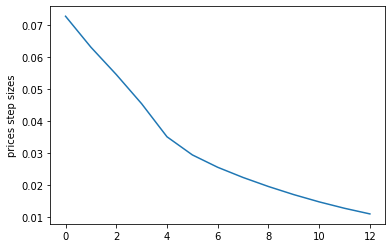

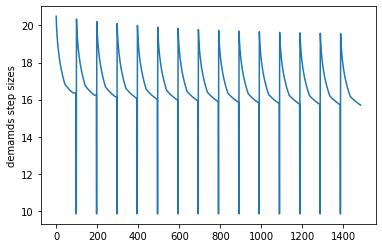

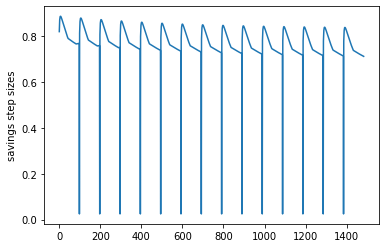

In [ ]:
num_goods = 5
num_buyers = 5
num_samples = 25
discount = 0.9

valuations = np.array([[0.50722067, 0.76313337, 0.05360443, 0.7501781,  0.67800042],
 [0.2274455,  0.06174344, 0.39171342, 0.1402779,  0.15473259],
 [0.16527965, 0.3476444,  0.36241701, 0.99000073, 0.75359852],
 [0.34999164, 0.68091931, 0.0310125,  0.17069236, 0.03813618],
 [0.02829523, 0.34238797, 0.69479688, 0.45690191, 0.4699344 ]])

# valuations = np.array([[21.26920423, 33.45640665],
#  [45.06020981, 23.52635807]])
valuations = valuations / (10 * np.sum(valuations))




learn_rate_prices_linear = 1 
learn_rate_prices_leontief = 1
learn_rate_prices_cd =  1

num_iters_prices = 60 #60
num_iters_demands = 100

value_coef = np.array([4.50812544, 4.76202112])
value_intercept = 0


budgets = np.array([9.79845395, 9.18667045])


utility_type = "linear"

# negative big 
# positive small

print(np.linalg.norm(value_coef))

learn_rate_prices = 1.4
# learn_rate_prices = (np.sum(budgets) / 1) * learn_rate_prices_cd * (1 / (np.linalg.norm(value_coef)/15+12))
learn_rate_demands = 0.015
# learn_rate_demands = (np.sum(budgets) / 800) * learn_rate_prices_cd * (1 / (np.linalg.norm(value_coef)/15+12))
print(learn_rate_prices)
print(learn_rate_demands)
# prices_step_sizes, demands_step_sizes, savings_step_sizes = min_max_linear_value_cvx_project(budgets, valuations, value_coef, value_intercept, 
#                                                                                  discount, learn_rate_prices, learn_rate_demands, 
#                                                                                 num_iters_prices, num_iters_demands, utility_type)

prices_step_sizes, demands_step_sizes, savings_step_sizes = min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, 
                                                                                 discount, learn_rate_prices, learn_rate_demands, 
                                                                                num_iters_prices, num_iters_demands, utility_type, test=True)
plt.plot(prices_step_sizes[1:])
plt.ylabel("prices step sizes")
plt.show()

plt.plot(demands_step_sizes[1:])
plt.ylabel("demamds step sizes")
plt.show()

plt.plot(savings_step_sizes[1:])
plt.ylabel("savings step sizes")
plt.show()

# 9.1 -- 94.68
# 9.9 -- 102.21

In [ ]:
0.23064679292222323

#### Value Iteration

In [ ]:
# The main function for value iteration
def fitted_linear_val_iter(valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands,
                                                                    num_iters_VI, num_iters_prices,  num_iters_demands, 
                                                                    num_samples, utility_type):
    coef_hist = [value_coef]
    intercept_hist = [value_intercept]
    values_hist = []
    budgets_hist = []
    
    num_buyers = valuations.shape[0]
    num_goods = valuations.shape[1]

    budgets_samples = np.random.uniform(9, 10, (num_samples, num_buyers))
    for iter in range(num_iters_VI):
        print(f"----------Value Iteration {iter}------------")
        values = []
        
        for index, budgets in enumerate(budgets_samples): 
            print(f"_____Sample {index}_____")
            # value, prices, allocations, savings = min_max_linear_value_manual_project(budgets, valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, num_iters_prices, num_iters_demands, utility_type)
            # real_learn_rate_prices = (np.sum(budgets) / 1) * learn_rate_prices * (1 / (np.linalg.norm(value_coef)/15+12))
            # real_learn_rate_demands = (np.sum(budgets) / 800) * learn_rate_prices * (1 / (np.linalg.norm(value_coef)/15+12))
            real_learn_rate_prices = 1.4
            real_learn_rate_demands = 0.015
            value, prices, allocations, savings = min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, 
                                                                                   discount, real_learn_rate_prices, real_learn_rate_demands, 
                                                                                   num_iters_prices, num_iters_demands, utility_type, test=False)
            values.append(value)
        
        values = np.array(values)
        

        reg = linear_model.LinearRegression()
        reg.fit(budgets_samples, values)
        value_coef = reg.coef_ # Update the parameters
        value_intercept = reg.intercept_ # Update the intercept
        
        coef_hist.append(value_coef)
        intercept_hist.append(value_intercept)
        values_hist.append(values)
        budgets_hist.append(budgets_samples)

        print("value coef:", value_coef)
        print("value_intercept:", value_intercept)
        print("---------------------------------------------------------------------------------------------------------")

        # coef_hist_filename = f"/content/drive/My Drive/exp_results_{utility_type}_new_valfunc/coef_hist_{iter}_{utility_type}_fisher.npy"
        # intercept_hist_filename = f"/content/drive/My Drive/exp_results_{utility_type}_new_valfunc/intercept_hist_{iter}_{utility_type}_fisher.npy"
        # values_hist_filename = f"/content/drive/My Drive/exp_results_{utility_type}_new_valfunc/values_hist_{iter}_{utility_type}_fisher.npy"
        # budgets_hist_filename = f"/content/drive/My Drive/exp_results_{utility_type}_new_valfunc/budgets_hist_{iter}_{utility_type}_fisher.npy"
        # with open(coef_hist_filename, 'wb') as f:
        #     np.save(f, coef_hist)

        # with open(intercept_hist_filename, 'wb') as f:
        #     np.save(f, intercept_hist)

        # with open(values_hist_filename, 'wb') as f:
        #     np.save(f, values_hist)


        # with open(budgets_hist_filename, 'wb') as f:
        #     np.save(f, budgets_hist)

    return (coef_hist, intercept_hist, values_hist, budgets_hist)


### Experiments

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

num_goods = 2
num_buyers = 2
discount = 0.9
value_coef = np.repeat(5, num_buyers)
value_intercept = 0


valuations = np.array([[21.26920423, 33.45640665],
 [45.06020981, 23.52635807]])

learn_rate_prices = 1
learn_rate_demands = 1
num_iters_VI = 30
num_iters_prices = 60 #10
num_iters_demands = 100 #20
num_samples = 25 #25



coef_hist_linear, intercept_hist_linear, values_hist_linear, budgets_hist_linear = fitted_linear_val_iter(valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands,
                                                                    num_iters_VI, num_iters_prices, num_iters_demands, 
                                                                    num_samples, "linear")

# coef_hist_leontief, intercept_hist_leontief, values_hist_leontief, budgets_hist_leontief = fitted_linear_val_iter(valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands,
#                                                                     num_iters_VI, num_iters_prices, num_iters_demands, 
#                                                                     num_samples, "leontief")

# coef_hist_cd, intercept_hist_cd, values_hist_cd, budgets_hist_cd = fitted_linear_val_iter(valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, 
#                                                                     num_iters_VI, num_iters_prices, num_iters_demands, 
#                                                                     num_samples, "cd")


Streaming output truncated to the last 5000 lines.
_____Sample 14_____

****Min-Max Price Iteration 10****
Early end! Excess demand norm: 0.0098935868398701
------------------------------------------------------------------
budgets: [9.88825678 9.31426444]
demands: [[1.76259571e-02 9.90816353e-01]
 [9.78693799e-01 2.71814100e-08]]
prices: [9.51703541 9.81060668]
value: 662.7513
excess demands: [-0.00368024 -0.00918362]
_____Sample 15_____

****Min-Max Price Iteration 10****
Early end! Excess demand norm: 0.009834632713869489
------------------------------------------------------------------
budgets: [9.34017393 9.27209123]
demands: [[3.62307486e-08 9.93379525e-01]
 [9.92727438e-01 2.40112565e-08]]
prices: [9.34001657 9.40242169]
value: 660.13245
excess demands: [-0.00727253 -0.00662045]
_____Sample 16_____
Early end! Excess demand norm: 0.009701259625983033
------------------------------------------------------------------
budgets: [9.86433576 9.80388041]
demands: [[2.66266484e-08 9.94

#### Save results

In [ ]:
print(coef_hist_linear)
print(intercept_hist_linear)

[array([5, 5]), array([4.46554068, 4.8848106 ]), array([4.46386686, 4.88845749]), array([4.46387021, 4.88845194]), array([4.46386377, 4.88846058]), array([4.46387021, 4.88845194]), array([4.46386377, 4.88846058]), array([4.46386377, 4.88846058]), array([4.46387143, 4.88844054]), array([4.46387049, 4.88846439]), array([4.46387049, 4.88846439]), array([4.46387049, 4.88846439]), array([4.46387049, 4.88846439]), array([4.46387049, 4.88846439]), array([4.46387049, 4.88846439]), array([4.46387049, 4.88846439]), array([4.46387049, 4.88846439]), array([4.46387049, 4.88846439]), array([4.46387049, 4.88846439]), array([4.46387049, 4.88846439]), array([4.46387049, 4.88846439]), array([4.46387049, 4.88846439]), array([4.46387049, 4.88846439]), array([4.46387049, 4.88846439]), array([4.46387049, 4.88846439]), array([4.46387049, 4.88846439]), array([4.46387049, 4.88846439]), array([4.46387049, 4.88846439]), array([4.46387049, 4.88846439]), array([4.46387049, 4.88846439]), array([4.46387049, 4.888464

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


#### Save Linear data ##### 

with open('/content/drive/My Drive/exp_results/jax_savings/coef_hist_linear_fisher.npy', 'wb') as f:
    np.save(f, coef_hist_linear)

with open('/content/drive/My Drive/exp_results/jax_savings/intercept_hist_linear_fisher.npy', 'wb') as f:
    np.save(f, intercept_hist_linear)

with open('/content/drive/My Drive/exp_results/jax_savings/values_hist_linear_fisher.npy', 'wb') as f:
    np.save(f, values_hist_linear)

with open('/content/drive/My Drive/exp_results/jax_savings/budgets_hist_linear_fisher.npy', 'wb') as f:
    np.save(f, budgets_hist_linear)


# ##### Save Cobb-Douglas data #####
# with open('/content/drive/My Drive/exp_results_cd/coef_hist_cd_fisher.npy', 'wb') as f:
#     np.save(f, coef_hist_cd)

# with open('/content/drive/My Drive/exp_results_cd/intercept_hist_cd_fisher.npy', 'wb') as f:
#     np.save(f, intercept_hist_cd)

# with open('/content/drive/My Drive/exp_results_cd/values_hist_cd_fisher.npy', 'wb') as f:
#     np.save(f, values_hist_cd)


# ##### Save Leontief data ##### 
# with open('/content/drive/My Drive/exp_results/budgets_hist_cd_fisher.npy', 'wb') as f:
#     np.save(f, budgets_hist_cd)

# with open('/content/drive/My Drive/exp_results/coef_hist_leontief_fisher.npy', 'wb') as f:
#     np.save(f, coef_hist_leontief)

# with open('/content/drive/My Drive/exp_results/intercept_hist_leontief_fisher.npy', 'wb') as f:
#     np.save(f, intercept_hist_leontief)

# with open('/content/drive/My Drive/exp_results/values_hist_leontief_fisher.npy', 'wb') as f:
#     np.save(f, values_hist_leontief)

# with open('/content/drive/My Drive/exp_results/budgets_hist_leontief_fisher.npy', 'wb') as f:
#     np.save(f, budgets_hist_leontief)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
